# Cross section computation using the Discrete Integral Transform (DIT) for rapid spectral synthesis

We demonstarte the Discrete Integral Transform (DIT) method proposed by D.C.M van den Bekerom and E.Pannier. DIT takes advantage especially for the case that the number of the molecular line is large (typically > 10,000). We here compare the results by DIT with the direct computation (LPF).  



In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import jax.numpy as jnp
plt.style.use('bmh')

In [2]:
from exojax.spec.hitran import SijT, doppler_sigma, gamma_hitran, gamma_natural
from exojax.spec import moldb

# Setting wavenumber bins and loading HITRAN database
nus=np.linspace(1900.0,2300.0,350000,dtype=np.float64) 
mdbCO=moldb.MdbHit('05_hit12.par',nus)

# set T, P and partition function
Mmol=28.01 # molecular weight
Tfix=1000.0 # we assume T=1000K
Pfix=1.e-3 # we compute P=1.e-3 bar
Ppart=Pfix #partial pressure of CO. here we assume a 100% CO atmosphere.
qt=mdbCO.qr_interp_lines(Tfix)

# compute Sij, gamma_L, sigmaD 
Sij=SijT(Tfix,mdbCO.logsij0,mdbCO.nu_lines,mdbCO.elower,qt)
gammaL = gamma_hitran(Pfix,Tfix, Ppart, mdbCO.n_air, \
                      mdbCO.gamma_air, mdbCO.gamma_self) \
+ gamma_natural(mdbCO.A)
sigmaD=doppler_sigma(mdbCO.nu_lines,Tfix,Mmol)

HAPI initializes all the par files in  .
HAPI detected: Forward modeling using the DIT Cross Section for methane.ipynb
HAPI detected: Terminal Velocity of Cloud Particles.ipynb
HAPI detected: 05_hit12.par
HAPI detected: Forward modeling.ipynb
HAPI detected: Forward modeling using the MODIT Cross Section for methane.ipynb
HAPI detected: Rigid Rotation.ipynb
HAPI detected: Forward modeling using DIT.ipynb
HAPI detected: .ipynb_checkpoints
HAPI detected: vaex-convert-1f7de26ff5e46c6cd6f456775faddfd5.lock
HAPI detected: vaex-convert-656477ba679eac5ad568c11eb73db957.lock
HAPI detected: Cross Section using Discrete Integral Transform.ipynb
HAPI detected: Untitled.ipynb
HAPI detected: Reducing memory for HITEMP.ipynb
HAPI detected: plg_ch4_tutorial.ipynb
HAPI detected: 05_hit12.header
HAPI detected: H2-H2_2011
HAPI detected: optimize_voigt.ipynb
HAPI detected: Reverse modeling for methane using MODIT.ipynb
HAPI detected: Comparing HITEMP and ExoMol.ipynb
HAPI detected: vaex-convert-e3ba488096

DIT uses a grid of sigmaD, gammaL, and wavenumber.   
ditgrid_log_interval makes a 1D grid for sigmaD and gamma.

In [3]:
from exojax.spec.set_ditgrid import ditgrid_log_interval
sigmaD_grid=ditgrid_log_interval(sigmaD)
gammaL_grid=ditgrid_log_interval(gammaL)

# we can change the resolution using res option
#sigmaD_grid=ditgrid_log_interval(sigmaD,dit_grid_resolution=0.1)
#gammaL_grid=ditgrid_log_interval(gammaL,dit_grid_resolution=0.1)

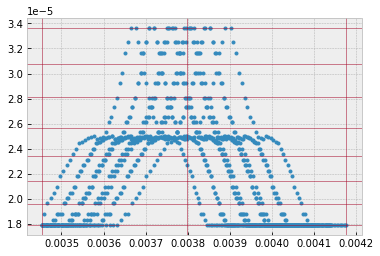

In [4]:
#show the grids
plt.plot(sigmaD,gammaL,".")
for i in sigmaD_grid:
    plt.axvline(i,lw=1,alpha=0.5,color="C1")
for i in gammaL_grid:
    plt.axhline(i,lw=1,alpha=0.5,color="C1")

We need to precompute the contribution for wavenumber. Also, pmarray is needed. These can be computed using init_dit. 

In [5]:
from exojax.spec import initspec 
cnu,indexnu,pmarray=initspec.init_dit(mdbCO.nu_lines,nus)

Then, let's compute a cross section!

In [6]:
from exojax.spec.dit import xsvector
xs=xsvector(cnu,indexnu,pmarray,sigmaD,gammaL,Sij,nus,sigmaD_grid,gammaL_grid)

Also, we here try the direct computation using LPF for the comparison purpose

In [7]:
from exojax.spec import xsection
xsv=xsection(nus,mdbCO.nu_lines,sigmaD,gammaL,Sij,memory_size=30) 

100%|█████████████████████████████████████████████████| 54/54 [00:03<00:00, 15.53it/s]


The difference is <~ 1%.

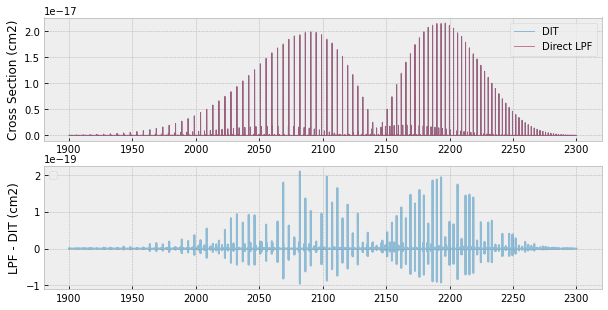

In [8]:
fig=plt.figure(figsize=(10,5))
ax=fig.add_subplot(211)
plt.plot(nus,xs,lw=1,alpha=0.5,label="DIT")
plt.plot(nus,xsv,lw=1,alpha=0.5,label="Direct LPF")
plt.legend(loc="upper right")
plt.ylabel("Cross Section (cm2)")
ax=fig.add_subplot(212)
#plt.plot(nus,xsv-xs,lw=2,alpha=0.5,label="precomputed")
plt.plot(nus,xsv-xs,lw=2,alpha=0.5)
plt.ylabel("LPF - DIT (cm2)")
plt.legend(loc="upper left")
plt.show()